# Прогнозирование оттока клиентов оператора связи

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

# План работы над задачей

1. Исследовательский анализ данных. Обнаружение аномалий, пропусков, выбросов, интересных фактов и зависимостей.
2. Преобработка данных. Выделение признаков и целевого признака в отдельные переменные, подготовка данных для обучения модели(кодирование, масштабирование, создание тестовой, валидационной, обучающией выборки) 
3. Обучение моделей для решения задачи классификации. Подбор гиперпараметров модели. Поиск наилучшей модели. 
4. Проверка модели на тестовой выборке.
5. Оформление отчета.

# **Исследовательский анализ данных**

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#импорт необходимых библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from numpy import array
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.dummy import DummyClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import catboost
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
from catboost import cv
from catboost import Pool
from catboost import CatBoostClassifier
from sklearn.utils import shuffle

In [3]:
# чтение данных
try:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv')   
except:
    contract = pd.read_csv('contract.csv')
    personal = pd.read_csv('personal.csv')
    internet = pd.read_csv('internet.csv')
    phone = pd.read_csv('phone.csv')

In [4]:
datasets=[( 'contract', contract), ('personal', personal), ('internet', internet), ('phone', phone)]
for name, value in datasets:
    print(name)
    display(value.head())
    print(value.info())

contract


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None
personal


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None
internet


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None
phone


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


## Описание данных 

Датасет `contract` содержит следующие колонки:
* `customerID` - уникальный индификатор пользователя
* `BeginDate` - дата заключения договора на оказание услуг
* `EndDate` - дата расторжения договора на оказание услуг
* `Type` - тип оплаты услуг, каждый месяц или за 1-2 года
* `PaperlessBilling` - наличие бумажного счета
* `PaymentMethod` - способ оплаты
* `MonthlyCharges` - ежемесячные платежи
* `TotalCharges` - общая сумма платежа

Пропусков в дынных нет.

Датасет `personal` содержит следующие колонки:
* `customerID` - уникальный индификатор пользователя
* `gender` - пол клиента
* `SeniorCitizen` - является ли клиент пенсионером или нет. 0-не является, 1-является.
* `Partner` - наличие партнера
* `Dependents` - наличие иждевенцев у клиента

Пропусков в данных нет.

Датасет `internet` содержит следующие колонки: 
* `customerID` - уникальный индификатор пользователя
* `InternetService` - подключенный интернет сервис. DSL - цифровая абонентская линия, Fiber optic-оптоволоконный кабель
* `OnlineSecurity` - возможность блокировки небезопасных каналов
* `OnlineBackup` - наличие облачного хранилища файлов для резервного копирования данных
* `DeviceProtection` - наличие антивируса
* `TechSupport` - наличие выделенной линии технической поддержки
* `StreamingTV` - наличие стримингового телевидения
* `StreamingMovies` - наличие каталога фильмов

Пропусков в данных нет.

Датасет `phone` содержит следующие колонки:
* `customerID` - уникальный индификатор пользователя
* `MultipleLines` - возможность подключения аппарата к нескольким линиям одновременно

##  Анализ таблицы `contract`

Проверим наличие дубликатов.

In [5]:
contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


In [6]:
contract.duplicated().sum()

0

In [7]:
contract['customerID'] = contract['customerID'].str.lower()

In [8]:
contract.duplicated().sum()

0

In [9]:
contract['customerID'] = contract['customerID'].str.upper()

Дубликатов нет.

Посмотрим за какой период предоставлены данные.

In [10]:
# изменим тип данных в колонке с датой
contract['BeginDate'] = pd.to_datetime(contract['BeginDate']) 

Text(0.5, 1.0, 'The year of begin contract')

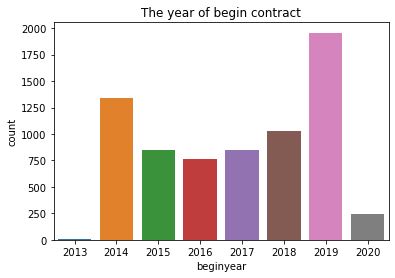

In [11]:
# построим диаграмму
contract['beginyear'] = contract['BeginDate'].dt.year
sns.countplot(contract['beginyear']);
plt.title('The year of begin contract')

2019 - год с наибольшим количиством заключенных контрактов.

['Yes' 'No']


Text(0.5, 1.0, 'PaperlessBillin counter')

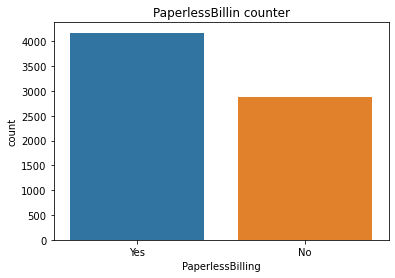

In [12]:
print(contract['PaperlessBilling'].unique())
sns.countplot(contract['PaperlessBilling']);
plt.title('PaperlessBillin counter')

Люди предпочитают электронную версию подтверждения оплаты.

Text(0.5, 1.0, 'PaymentMethod')

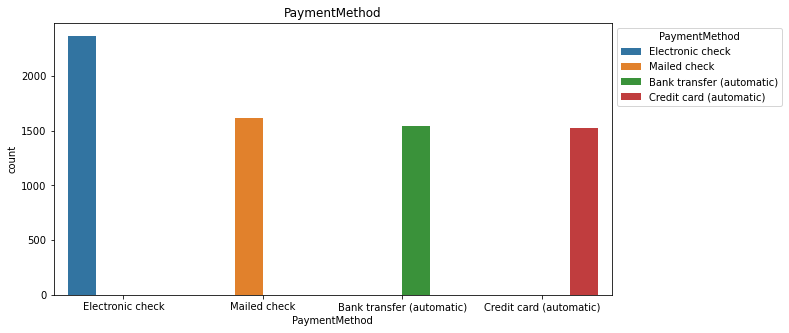

In [13]:
plt.figure(figsize=(10,5))
ax = sns.countplot(contract['PaymentMethod'], hue= contract['PaymentMethod'])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('PaymentMethod')

Предпочтительный способ оплаты услуг - электронный чек.

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64


Text(0.5, 1.0, 'Boxplot for MonthlyCharge')

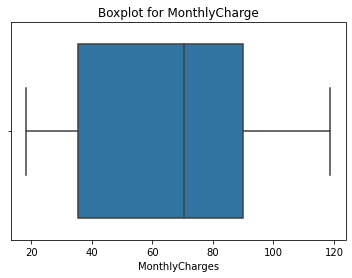

In [14]:
sns.boxplot(contract['MonthlyCharges']);
print(contract['MonthlyCharges'].describe())
plt.title('Boxplot for MonthlyCharge')

В колонке с общей суммой платежа в некоторых строках находятся пробелы, заменим их на Nan и посчитаем их количество.

In [15]:
contract['TotalCharges'] = contract['TotalCharges'].replace(' ', np.nan)

In [16]:
print('Всего некоректных данных:', contract['TotalCharges'].isna().sum())
display(contract[contract['TotalCharges'].isnull()])

Всего некоректных данных: 11


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,beginyear
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,2020
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN,2020
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN,2020
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN,2020
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN,2020
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN,2020
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN,2020
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN,2020
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN,2020
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN,2020


Значения с Nan это клиенты, которые только заключили контракт на момент выгрузки данных. Поэтому их полной оплаты еще нет.

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64


Text(0.5, 1.0, 'Boxplot for TotalCharges')

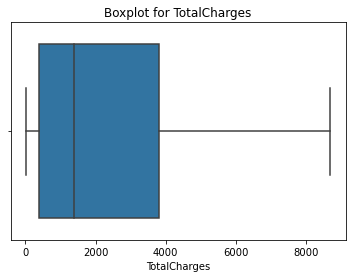

In [17]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'])
sns.boxplot(contract['TotalCharges']);
print(contract['TotalCharges'].describe())
plt.title('Boxplot for TotalCharges')

Выбросов в значениях платежей нет. Значение медианы для месячного платежа составляет - 70.35, а для полной суммы платежа 1397.475.

### Вывод

* Дубликатов в данных нет.
* Всего 7043 пользователя, из них 1869 отказались от услуг компании. Все 1869 пользователей прекратили использование услуг в конце 2019 года и начале 2020. Больше всего договор на предоставление услуг было заключено в 2019.
* Пользователи предпочитают бумажную версию чека и электронный способ оплаты.
* Пользователи предпочитают оплату ежимесячно, а не заключение договора на 1-2 года.

## Анализ таблицы `personal`

In [18]:
personal

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [19]:
# уникальные значения колонки gender
personal['gender'].unique()

array(['Female', 'Male'], dtype=object)

Посмотрим пользователей, какого пола больше.

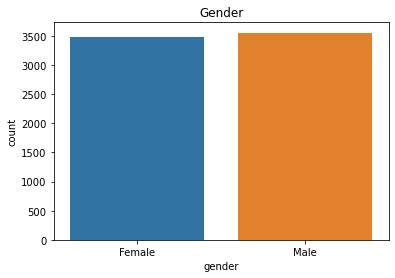

In [20]:
sns.countplot(personal['gender'])
plt.title('Gender');

Соотношение мужчин и женщин среди пользователей практически одинаково.

In [21]:
personal.pivot_table(index=['Dependents','gender'] , values='customerID', aggfunc='count')

customerID
Dependents gender            
No         Female        2460
           Male          2473
Yes        Female        1028
           Male          1082

Мужчин и женщин имещих иждевенцов практически одинаковое количество.

In [22]:
personal.pivot_table(index=['Partner','gender'] , values='customerID', aggfunc='count')

customerID
Partner gender            
No      Female        1800
        Male          1841
Yes     Female        1688
        Male          1714

Количество мужчин пользователей без партнера на 41 больше, чем женщин. Количество женщих имеющих партнера на 26 меньше, чем мужчин.

In [23]:
personal['SeniorCitizen'].unique()

array([0, 1])

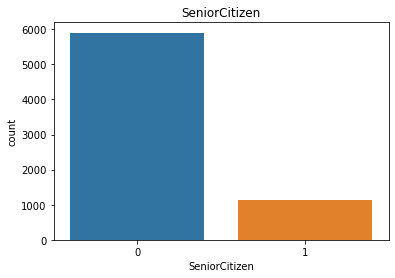

In [24]:
sns.countplot(personal['SeniorCitizen'])
plt.title('SeniorCitizen');

Количество работающих пользователей превышает количество пенсионеров.

### Вывод

* Среди пользователей количество мужчин и женщин практически одинаково. Также практически одинаковое количество мужчин и женщим содержат иждевенцев и находятся в отношениях.
* Число работающих пользователей преобладает над числом пенсионеров.

## Анализ таблицы `internet`

In [25]:
internet

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [26]:
# уникальные значения
columns= internet.drop('customerID', axis=1)
for i in columns:
    print(internet[i].unique())

['DSL' 'Fiber optic']
['No' 'Yes']
['Yes' 'No']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']


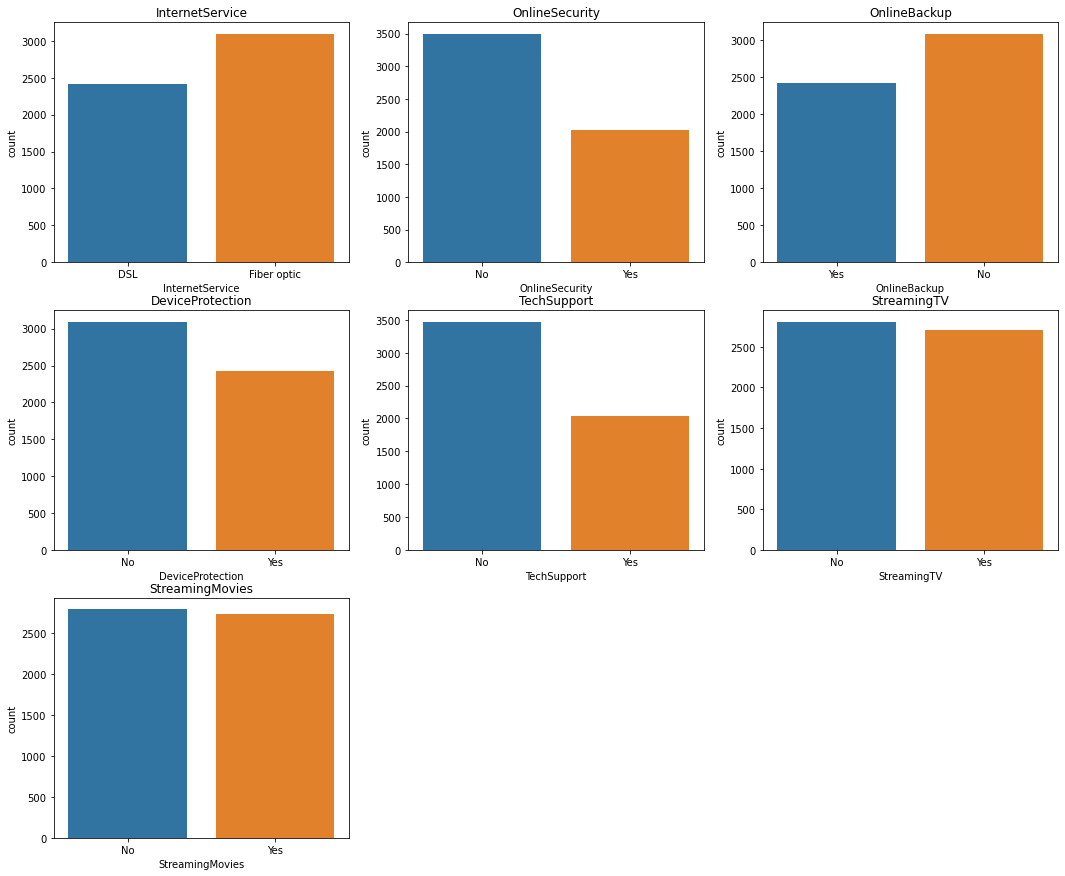

In [27]:
plt.figure(figsize=(18,15))
for i in range(0, 7):
    plt.subplot(3, 3, i+1)
    sns.countplot(columns[columns.columns[i]])
    plt.title(columns.columns[i])

In [28]:
internet.query('StreamingTV == "Yes" & StreamingMovies == "Yes"').count()[0]

1940

In [29]:
internet.query('OnlineSecurity == "Yes" & OnlineBackup == "Yes" & DeviceProtection == "Yes" & TechSupport == "Yes"').count()[0]

470

### Вывод:

* Пользователи предпочитают оптоволоконный кабель больше, чем цифровая абонентская линия.
* Зачастую пользователи отказываются от использования антивируса, блокировки небезопасных сайтов, а также от облачного хранилища файлов для резервного копирования данных.
* Пользователи поровну разделились на тех кто использует стриминговое телевиденье и каталог фильмов и тех кто отказывается от услуги.
* Из 7043 пользователей, 5517 пользуются услугами интернета. 
* Только 470 пользователей используют максимальный пакет дополнительных услуг.

## Анализ таблицы `phone`

In [30]:
phone

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


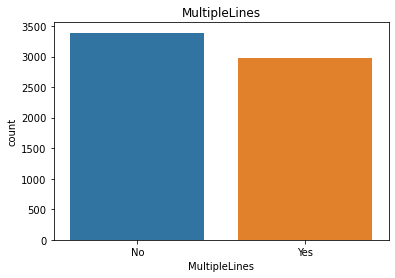

In [31]:
sns.countplot(phone['MultipleLines'])
plt.title('MultipleLines');

### Вывод

* Из 7043 пользователей, 6361 пользуются услугами стационарной телефонной связью.
* Большинство из них не имеют возможности подключения телефонного аппарата к нескольким линиям одновременно.

Проверим у всех ли пользователей подключена одна из услуг: интернет или телефон.

In [32]:
internet_id = internet.set_index('customerID')
phone_id = phone.set_index('customerID')

In [33]:
df_join = internet_id.join(phone_id, on='customerID', how='outer')

In [34]:
df_join.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to nan
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
 8   MultipleLines     6361 non-null   object
dtypes: object(9)
memory usage: 550.2+ KB


In [35]:
have_not_internet = df_join[df_join['InternetService'].isnull()] 
have_not_internet[have_not_internet['MultipleLines'].isnull()] 

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines


In [36]:
have_not_phone = df_join[df_join['MultipleLines'].isnull()] 
have_not_phone[have_not_phone['InternetService'].isnull()]

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines


Из всех пользователей у 1526 не подключен интернет, но подключен телефон и у 682 подключен интернет, но не подключен телефон. Остальные пользователи пользуются и телефоном и интернетом.

# Подготовка целевого признака и признаков 

Мы решаем задачу бинарной классификации, поэтому целевым признаком будет являтся колонка EndDate, в которой есть информация отказался ли пользователь от предоставляемых услуг или сотрудничает с компанией.

In [37]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,beginyear
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,2020
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,2017
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,2019
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,2016
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,2019


Вычислим время жизни клиента

In [38]:
contract['EndDate'] = contract['EndDate'].replace('No', '2020-02-01')
contract['EndDate'] = pd.to_datetime(contract['EndDate']) 
contract['life_cycle'] = contract['EndDate'] - contract['BeginDate']
contract['life_cycle'] = contract['life_cycle'].astype('timedelta64[D]')

In [39]:
contract.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,beginyear,life_cycle
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,2020,31.0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,2017,1036.0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,2019,61.0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,2016,1371.0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,2019,61.0


In [40]:
contract.life_cycle.describe()

count    7043.000000
mean      985.996166
std       747.587844
min         0.000000
25%       273.000000
50%       883.000000
75%      1676.000000
max      2191.000000
Name: life_cycle, dtype: float64

Преобразуем колонку с информацией о целевом признаке. Где 0- будет означать что пользователь пользуется услугами до сих пор, а 1 - пользователь ушел от компании.

In [41]:
contract['EndDate'] = contract['EndDate'].astype('str')
contract['EndDate'] = contract['EndDate'].apply(lambda x: 0 if x == '2020-02-01' else 1)

In [42]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,beginyear,life_cycle
0,7590-VHVEG,2020-01-01,0,Month-to-month,Yes,Electronic check,29.85,29.85,2020,31.0
1,5575-GNVDE,2017-04-01,0,One year,No,Mailed check,56.95,1889.50,2017,1036.0
2,3668-QPYBK,2019-10-01,1,Month-to-month,Yes,Mailed check,53.85,108.15,2019,61.0
3,7795-CFOCW,2016-05-01,0,One year,No,Bank transfer (automatic),42.30,1840.75,2016,1371.0
4,9237-HQITU,2019-09-01,1,Month-to-month,Yes,Electronic check,70.70,151.65,2019,61.0


Удалим колонки, которые не будут использоваться как признаки.

In [43]:
contract = contract.drop(['BeginDate', 'beginyear'], axis=1)

Пользователи, которые заключили контракт на момент выгрузки данных, заключили его на 1 и 2 года, нам известно что в случае заключения такого контракта пользователи платят всю сумму сразу. У нас есть сумма, которую они бы платили в месяц, отсюда вычислим стоимость, которую они оплатили сразу и заполним недостающие данные в колонке  `TotalCharges`.

In [44]:
display(contract[contract['TotalCharges'].isnull()])

,customerID,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,life_cycle
488,4472-LVYGI,0,Two year,Yes,Bank transfer (automatic),52.55,NaN,0.0
753,3115-CZMZD,0,Two year,No,Mailed check,20.25,NaN,0.0
936,5709-LVOEQ,0,Two year,No,Mailed check,80.85,NaN,0.0
1082,4367-NUYAO,0,Two year,No,Mailed check,25.75,NaN,0.0
1340,1371-DWPAZ,0,Two year,No,Credit card (automatic),56.05,NaN,0.0
3331,7644-OMVMY,0,Two year,No,Mailed check,19.85,NaN,0.0
3826,3213-VVOLG,0,Two year,No,Mailed check,25.35,NaN,0.0
4380,2520-SGTTA,0,Two year,No,Mailed check,20.00,NaN,0.0
5218,2923-ARZLG,0,One year,Yes,Mailed check,19.70,NaN,0.0
6670,4075-WKNIU,0,Two year,No,Mailed check,73.35,NaN,0.0


In [45]:
type_ = {'Two year' : 24,
         'One year' : 12,
         'Month-to-month': 1}
contract['month_type'] = contract['Type'].apply(lambda x: type_.get(x))

In [46]:
contract['TotalCharges'] = contract['TotalCharges'].fillna(contract['MonthlyCharges']* contract['month_type'])
display(contract[contract['customerID'] == '5709-LVOEQ'])

,customerID,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,life_cycle,month_type
936,5709-LVOEQ,0,Two year,No,Mailed check,80.85,1940.4,0.0,24


In [47]:
# удалим вспомогательную колонку
contract = contract.drop('month_type', axis=1)

In [48]:
contract.head()

,customerID,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,life_cycle
0,7590-VHVEG,0,Month-to-month,Yes,Electronic check,29.85,29.85,31.0
1,5575-GNVDE,0,One year,No,Mailed check,56.95,1889.50,1036.0
2,3668-QPYBK,1,Month-to-month,Yes,Mailed check,53.85,108.15,61.0
3,7795-CFOCW,0,One year,No,Bank transfer (automatic),42.30,1840.75,1371.0
4,9237-HQITU,1,Month-to-month,Yes,Electronic check,70.70,151.65,61.0


In [49]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Объединим все признаки в одну таблицу

У всех колонак индексом сделаем `customerID`

In [50]:
contract= contract.set_index('customerID')
personal = personal.set_index('customerID')
internet = internet.set_index('customerID')
phone = phone.set_index('customerID')

In [51]:
data = contract.join(personal, on='customerID', how='left')
data.head()

,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,life_cycle,gender,SeniorCitizen,Partner,Dependents
customerID,,,,,,,,,,,
7590-VHVEG,0,Month-to-month,Yes,Electronic check,29.85,29.85,31.0,Female,0,Yes,No
5575-GNVDE,0,One year,No,Mailed check,56.95,1889.50,1036.0,Male,0,No,No
3668-QPYBK,1,Month-to-month,Yes,Mailed check,53.85,108.15,61.0,Male,0,No,No
7795-CFOCW,0,One year,No,Bank transfer (automatic),42.30,1840.75,1371.0,Male,0,No,No
9237-HQITU,1,Month-to-month,Yes,Electronic check,70.70,151.65,61.0,Female,0,No,No


In [52]:
data = data.join(internet, on='customerID', how='left')
data = data.join(phone, on='customerID', how='left')
data.head()

,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,life_cycle,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,Month-to-month,Yes,Electronic check,29.85,29.85,31.0,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,0,One year,No,Mailed check,56.95,1889.50,1036.0,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,1,Month-to-month,Yes,Mailed check,53.85,108.15,61.0,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,0,One year,No,Bank transfer (automatic),42.30,1840.75,1371.0,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,1,Month-to-month,Yes,Electronic check,70.70,151.65,61.0,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


При объединении таблиц возникли Nan. В колонках `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`	`TechSupport`, `StreamingTV`, `StreamingMovies`, `MultipleLines` заменим Nan.										Если у человека не подключен интернет сервис или телефон, Nan заменим на non_connection.							

In [53]:
list_columns = ['InternetService', 'OnlineSecurity', 
                'OnlineBackup', 'DeviceProtection',
                'TechSupport', 'StreamingTV', 
                'StreamingMovies', 'MultipleLines']
for i in list_columns:
    data[i] = data[i].fillna('non_connection')

In [54]:
data.head(2)

,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,life_cycle,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,Month-to-month,Yes,Electronic check,29.85,29.85,31.0,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,non_connection
5575-GNVDE,0,One year,No,Mailed check,56.95,1889.50,1036.0,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No


# **Подготовка данных для обучения модели**

Посмотрим на корреляцию признаков.

AxesSubplot(0.125,0.125;0.62x0.755)


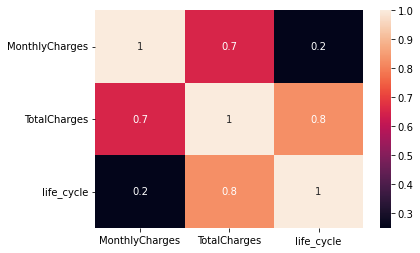

In [55]:
print(sns.heatmap(data[['MonthlyCharges', 'TotalCharges', 'life_cycle']].corr(),annot = True, fmt = '.1g'));

Высокая корреляция между признаками `TotalCharges` и `life_cycle` (0.8), а так же `MonthlyCharges` и `TotalCharges` - 0.7.

Выделим целевой признак и признаки в отдельные переменные.

In [56]:
target = data['EndDate']
features = data.drop(['EndDate'], axis=1)

## Преобразование категориальных переменных

Для преобразования категориальных переменных в численные используем метод One-Hot Encoding.

In [57]:
# воспользуемся техникой OHE для преобразования категориальных переменных
features_ohe = pd.get_dummies(features, drop_first=True)
features_ohe.shape

(7043, 29)

In [58]:
features_ohe.head(2)

,MonthlyCharges,TotalCharges,life_cycle,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,DeviceProtection_Yes,DeviceProtection_non_connection,TechSupport_Yes,TechSupport_non_connection,StreamingTV_Yes,StreamingTV_non_connection,StreamingMovies_Yes,StreamingMovies_non_connection,MultipleLines_Yes,MultipleLines_non_connection
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,29.85,29.85,31.0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
5575-GNVDE,56.95,1889.50,1036.0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0


Разделим данные на обучающую и тестовую выборку.

In [59]:
feature_train_full, feature_test_full, target_train_full, target_test_full = train_test_split(features_ohe,
                                                                                              target,
                                                                                              test_size=0.2,
                                                                                              random_state =80822)
print('Размер обучающей выборки:', feature_train_full.shape)
print('Размер тестовой выборки:', feature_test_full.shape)

Размер обучающей выборки: (5634, 29)
Размер тестовой выборки: (1409, 29)


**Масштабируем численные признаки**

In [60]:
pd.options.mode.chained_assignment = None
numeric = ['MonthlyCharges', 'TotalCharges', 'life_cycle']
scaler = StandardScaler()
scaler.fit(feature_train_full[numeric])
feature_train_full[numeric] = scaler.transform(feature_train_full[numeric])
feature_test_full[numeric] = scaler.transform(feature_test_full[numeric])

In [61]:
feature_train_full.head(2)

,MonthlyCharges,TotalCharges,life_cycle,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,DeviceProtection_Yes,DeviceProtection_non_connection,TechSupport_Yes,TechSupport_non_connection,StreamingTV_Yes,StreamingTV_non_connection,StreamingMovies_Yes,StreamingMovies_non_connection,MultipleLines_Yes,MultipleLines_non_connection
customerID,,,,,,,,,,,,,,,,,,,,,
7055-HNEOJ,-0.299404,-0.942339,-1.200630,0,0,0,1,0,0,1,...,1,0,1,0,0,0,0,0,0,0
0475-RIJEP,0.433702,0.478143,0.429236,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0


### Уменьшение размерности 

#### Выберем наилучшие признаки для обучения модели с помощью SelectKBest.

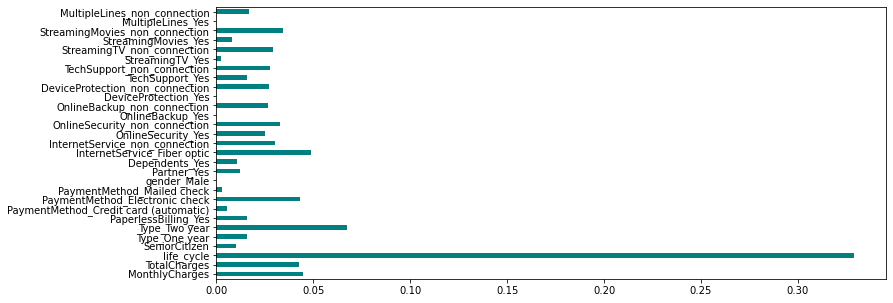

In [62]:
importances = mutual_info_classif(features_ohe, target)
feature_importances = pd.Series(importances,features_ohe.columns)
plt.figure(figsize=(12,5))
feature_importances.plot(kind='barh', color='teal')
plt.show()

Самым важным признаком является время жизни пользователя в компании, затем тип контракта и оплата услуг.

In [63]:
select = SelectKBest(score_func=chi2, k=10)
z = select.fit_transform(features_ohe, target)

In [64]:
filter = select.get_support()
features_b = array(features_ohe.columns)
print(features_b[filter])

['MonthlyCharges' 'TotalCharges' 'life_cycle' 'Type_Two year'
 'PaymentMethod_Electronic check' 'InternetService_Fiber optic'
 'DeviceProtection_non_connection' 'TechSupport_non_connection'
 'StreamingTV_non_connection' 'StreamingMovies_non_connection']


In [65]:
features_best = features_ohe[features_b[filter]]
features_best.head(2)

,MonthlyCharges,TotalCharges,life_cycle,Type_Two year,PaymentMethod_Electronic check,InternetService_Fiber optic,DeviceProtection_non_connection,TechSupport_non_connection,StreamingTV_non_connection,StreamingMovies_non_connection
customerID,,,,,,,,,,
7590-VHVEG,29.85,29.85,31.0,0,1,0,0,0,0,0
5575-GNVDE,56.95,1889.50,1036.0,0,0,0,0,0,0,0


Разделим данные на обучающую и тестовую выборку.

In [66]:
feature_train_best, feature_test_best, target_train_best, target_test_best = train_test_split(features_best,
                                                                                              target, 
                                                                                              test_size=0.2, 
                                                                                            random_state =80822)
print('Размер обучающей выборки:', feature_train_best.shape)
print('Размер тестовой выборки:', feature_test_best.shape)

Размер обучающей выборки: (5634, 10)
Размер тестовой выборки: (1409, 10)


**Масштабируем численные признаки**

In [67]:
numeric = ['MonthlyCharges', 'TotalCharges', 'life_cycle']
scaler = StandardScaler()
scaler.fit(feature_train_best[numeric])
feature_train_best[numeric] = scaler.transform(feature_train_best[numeric])
feature_test_best[numeric] = scaler.transform(feature_test_best[numeric])

In [68]:
feature_train_best.head(2)

,MonthlyCharges,TotalCharges,life_cycle,Type_Two year,PaymentMethod_Electronic check,InternetService_Fiber optic,DeviceProtection_non_connection,TechSupport_non_connection,StreamingTV_non_connection,StreamingMovies_non_connection
customerID,,,,,,,,,,
7055-HNEOJ,-0.299404,-0.942339,-1.200630,0,0,0,0,0,0,0
0475-RIJEP,0.433702,0.478143,0.429236,0,1,1,0,0,0,0


# **Обучение модели**

## Проверка моделей на адекватность

In [69]:
# функция позволяющая строить ROC-кривую
def curve(target, probabilities):
    fpr, tpr, thresholds = roc_curve(target, probabilities)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    return plt.show()

Для проверки нашей модели на адекватность будем использовать простейшую модель.

acc: 0.723207948899929
auc_roc: 0.5


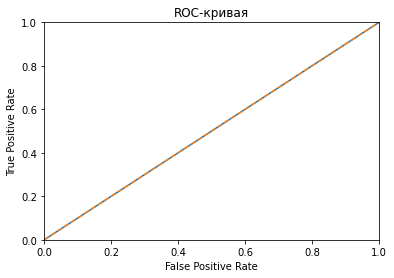

In [70]:
# Элементарная модель
model_random = DummyClassifier(random_state=80822, strategy='most_frequent')
model_random.fit(feature_train_full, target_train_full)
predictions = model_random.predict(feature_test_full)
acc = accuracy_score(target_test_full, predictions)
print(f'acc: {acc}')

probabilities_test = model_random.predict_proba(feature_test_full)
probabilities_one_test = probabilities_test[:, 1]
print(f'auc_roc: {roc_auc_score(target_test_full, probabilities_one_test)}')
curve(target_test_full, probabilities_one_test)

## **RandomForestClassifier,LogisticRegression, DecisionTreeClassifier, GradientBoostingClassifier**

In [71]:
model = LogisticRegression(random_state=80822, class_weight='balanced')

cross_val = cross_val_score(model, 
                            feature_train_full, 
                            target_train_full, 
                            scoring='roc_auc', cv=5, n_jobs=-1).mean()

print('Значение метрики ROC-AUC',cross_val)

Значение метрики ROC-AUC 0.8442141082525346


In [72]:
clf1 = RandomForestClassifier(random_state=80822)
clf2 = LogisticRegression(random_state=80822)
clf3 = DecisionTreeClassifier(random_state=80822)
clf4 = GradientBoostingClassifier(random_state=80822)

In [73]:
# для каждой модели параметры для подбора
param1 = {'n_estimators': range (10, 100),
         'max_depth': range (1,80),
         'class_weight': ['balanced', 'auto'],
         }

param2 = {'solver': ['liblinear', 'sag','saga','newton-cg']}

param3 = {'max_depth': range (1,80),
         'class_weight': ['balanced', 'auto'],
         'min_samples_split': range(2,8),
         }


param4 = {'n_estimators' : range(10,100),
         'max_depth' : range(1, 80),
         'learning_rate': np.arange(0.01, 0.2, 0.01),
         }

In [74]:
# обучение моделей на всех данных без выбора наилучших признаков
models = [clf1, clf2, clf3, clf4]
params = [param1, param2, param3, param4]
results = pd.DataFrame({'classificator': [],
                        'best_score': []})

for i in range(len(models)):
    rs = RandomizedSearchCV(models[i], params[i], cv=3, n_jobs=-1, scoring='roc_auc')
    rs.fit(feature_train_full, target_train_full)
    print(rs.best_params_, rs.best_score_, sep='\n')
    results = results.append({'classificator': models[i],
               'best_score': rs.best_score_}, ignore_index=True)
    
display(results)

{'n_estimators': 85, 'max_depth': 21, 'class_weight': 'balanced'}
0.83916637985955
{'solver': 'saga'}
0.8439232284473605
{'min_samples_split': 6, 'max_depth': 7, 'class_weight': 'balanced'}
0.8271356146093444
{'n_estimators': 41, 'max_depth': 8, 'learning_rate': 0.18000000000000002}
0.8866501661040364


,classificator,best_score
0,RandomForestClassifier(random_state=80822),0.839166
1,LogisticRegression(random_state=80822),0.843923
2,DecisionTreeClassifier(random_state=80822),0.827136
3,GradientBoostingClassifier(random_state=80822),0.886650


In [75]:
# обучение моделей после выбора наилучших параметров
models = [clf1, clf2, clf3, clf4]
params = [param1, param2, param3, param4]
results = pd.DataFrame({'classificator': [],
                        'best_score': []})

for i in range(len(models)):
    rs = RandomizedSearchCV(models[i], params[i], cv=3, n_jobs=-1, scoring='roc_auc')
    rs.fit(feature_train_best, target_train_best)
    print(rs.best_params_, rs.best_score_, sep='\n')
    results = results.append({'classificator': models[i],
               'best_score': rs.best_score_}, ignore_index=True)
    
display(results)

{'n_estimators': 51, 'max_depth': 15, 'class_weight': 'balanced'}
0.8410078035944867
{'solver': 'liblinear'}
0.8314660359351009
{'min_samples_split': 7, 'max_depth': 61, 'class_weight': 'balanced'}
0.7513428675341668
{'n_estimators': 26, 'max_depth': 2, 'learning_rate': 0.02}
0.8257923809384328


,classificator,best_score
0,RandomForestClassifier(random_state=80822),0.841008
1,LogisticRegression(random_state=80822),0.831466
2,DecisionTreeClassifier(random_state=80822),0.751343
3,GradientBoostingClassifier(random_state=80822),0.825792


Проверим наилучшую модель на тестовой выборке.

acc: 0.8488289567068843
auc_roc: 0.9060403613396744


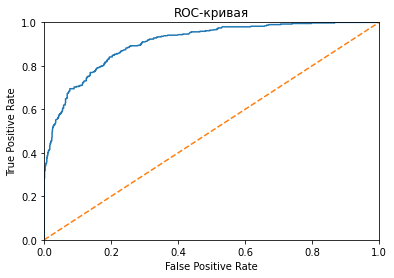

In [76]:
model = GradientBoostingClassifier(random_state=80822,
                               n_estimators= 74, max_depth = 4, learning_rate=0.16)

model.fit(feature_train_best, target_train_best)
predictions = model.predict(feature_test_best)
acc = accuracy_score(target_test_best, predictions)
print(f'acc: {acc}')

probabilities_test = model.predict_proba(feature_test_best)
probabilities_one_test = probabilities_test[:, 1]
print(f'auc_roc: {roc_auc_score(target_test_best, probabilities_one_test)}')
curve(target_test_full, probabilities_one_test)

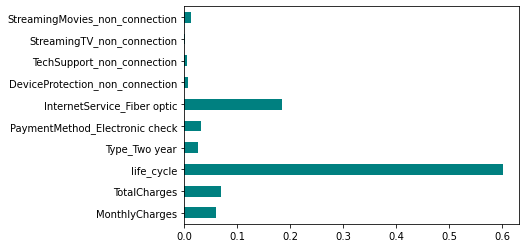

In [77]:
importance = model.feature_importances_
importance = pd.Series(importance, feature_train_best.columns)
importance.plot(kind='barh', color='teal')
plt.show()

### Вывод

Наилучшее значение метрики ROC-AUC при использовании всех признаков. Модель GradientBoostingClassifier показала наилучшее значение метрики на обучающей выборке 0.893. На тестовой выборке значение метркики ROC-AUC составило 0.905, а accuracy - 0.861.

## **Модель CatBoostClassifier**

В модель можно подавать категориальные признаки, поэтому разделим исходные необработанные данные на тестовую и обучающую выборку.

In [78]:
feature_train, feature_test, target_train, target_test = train_test_split(features,
                                                                          target,
                                                                          test_size=0.2,
                                                                          random_state =80822)
print('Размер обучающей выборки:', feature_train.shape)
print('Размер тестовой выборки:', feature_test.shape)

Размер обучающей выборки: (5634, 18)
Размер тестовой выборки: (1409, 18)


In [79]:
cat_features = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner', 
               'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
               'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

In [80]:
model_cb = CatBoostClassifier(eval_metric='AUC',
                             verbose=100,
                             loss_function='Logloss')

%time
params = {'learning_rate': [0.1,0.5,0.7,0.8],
        'depth': [2,3,5],
        'iterations': [500,1000],
        'class_weights': [[1, 2.77]]  
         }
cb_grid = GridSearchCV(model_cb, param_grid=params, cv=5)
cb_grid.fit(feature_train , target_train, cat_features=cat_features)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs
0:	total: 73ms	remaining: 36.4s
100:	total: 905ms	remaining: 3.57s
200:	total: 1.9s	remaining: 2.82s
300:	total: 2.8s	remaining: 1.85s
400:	total: 3.69s	remaining: 911ms
499:	total: 4.62s	remaining: 0us
0:	total: 8.61ms	remaining: 4.3s
100:	total: 768ms	remaining: 3.03s
200:	total: 1.67s	remaining: 2.49s
300:	total: 2.54s	remaining: 1.68s
400:	total: 3.43s	remaining: 847ms
499:	total: 4.3s	remaining: 0us
0:	total: 6.58ms	remaining: 3.28s
100:	total: 803ms	remaining: 3.17s
200:	total: 1.68s	remaining: 2.5s
300:	total: 2.59s	remaining: 1.71s
400:	total: 3.46s	remaining: 854ms
499:	total: 4.34s	remaining: 0us
0:	total: 8.57ms	remaining: 4.28s
100:	total: 812ms	remaining: 3.21s
200:	total: 1.69s	remaining: 2.51s
300:	total: 2.62s	remaining: 1.73s
400:	total: 3.53s	remaining: 872ms
499:	total: 4.65s	remaining: 0us
0:	total: 8.86ms	remaining: 4.42s
100:	total: 881ms	remaining: 3.48s
200:	total: 1.75s	remaining: 2.6s
300:	total: 2

600:	total: 5.89s	remaining: 3.91s
700:	total: 6.81s	remaining: 2.9s
800:	total: 7.72s	remaining: 1.92s
900:	total: 8.62s	remaining: 947ms
999:	total: 9.53s	remaining: 0us
0:	total: 6.98ms	remaining: 6.97s
100:	total: 853ms	remaining: 7.59s
200:	total: 1.85s	remaining: 7.37s
300:	total: 2.95s	remaining: 6.85s
400:	total: 3.96s	remaining: 5.92s
500:	total: 4.91s	remaining: 4.89s
600:	total: 5.83s	remaining: 3.87s
700:	total: 6.78s	remaining: 2.89s
800:	total: 7.71s	remaining: 1.92s
900:	total: 8.63s	remaining: 948ms
999:	total: 9.52s	remaining: 0us
0:	total: 8.54ms	remaining: 8.53s
100:	total: 1.23s	remaining: 10.9s
200:	total: 2.29s	remaining: 9.1s
300:	total: 3.38s	remaining: 7.84s
400:	total: 4.47s	remaining: 6.68s
500:	total: 5.53s	remaining: 5.51s
600:	total: 6.43s	remaining: 4.27s
700:	total: 7.34s	remaining: 3.13s
800:	total: 8.49s	remaining: 2.11s
900:	total: 9.54s	remaining: 1.05s
999:	total: 10.9s	remaining: 0us
0:	total: 8.46ms	remaining: 8.45s
100:	total: 1.11s	remaining: 9.

300:	total: 4.82s	remaining: 11.2s
400:	total: 6.12s	remaining: 9.15s
500:	total: 7.48s	remaining: 7.45s
600:	total: 8.97s	remaining: 5.96s
700:	total: 10.5s	remaining: 4.48s
800:	total: 12.2s	remaining: 3.03s
900:	total: 13.7s	remaining: 1.5s
999:	total: 15.2s	remaining: 0us
0:	total: 11.4ms	remaining: 11.4s
100:	total: 1.24s	remaining: 11s
200:	total: 2.55s	remaining: 10.1s
300:	total: 3.92s	remaining: 9.09s
400:	total: 5.76s	remaining: 8.6s
500:	total: 10.2s	remaining: 10.1s
600:	total: 12.2s	remaining: 8.09s
700:	total: 13.9s	remaining: 5.92s
800:	total: 15.8s	remaining: 3.94s
900:	total: 17.5s	remaining: 1.92s
999:	total: 19.3s	remaining: 0us
0:	total: 12.5ms	remaining: 12.5s
100:	total: 1.46s	remaining: 13s
200:	total: 3.02s	remaining: 12s
300:	total: 4.57s	remaining: 10.6s
400:	total: 6.11s	remaining: 9.13s
500:	total: 7.56s	remaining: 7.53s
600:	total: 8.9s	remaining: 5.91s
700:	total: 10.2s	remaining: 4.37s
800:	total: 12.1s	remaining: 3s
900:	total: 13.5s	remaining: 1.49s
999

300:	total: 6.87s	remaining: 4.54s
400:	total: 9.17s	remaining: 2.26s
499:	total: 11.5s	remaining: 0us
0:	total: 19.9ms	remaining: 9.93s
100:	total: 2.14s	remaining: 8.46s
200:	total: 4.4s	remaining: 6.55s
300:	total: 7s	remaining: 4.63s
400:	total: 9.52s	remaining: 2.35s
499:	total: 11.8s	remaining: 0us
0:	total: 21.8ms	remaining: 10.9s
100:	total: 2.22s	remaining: 8.77s
200:	total: 4.66s	remaining: 6.93s
300:	total: 6.94s	remaining: 4.59s
400:	total: 9.29s	remaining: 2.29s
499:	total: 11.6s	remaining: 0us
0:	total: 21.7ms	remaining: 10.9s
100:	total: 2.43s	remaining: 9.59s
200:	total: 4.76s	remaining: 7.09s
300:	total: 7.14s	remaining: 4.72s
400:	total: 9.46s	remaining: 2.33s
499:	total: 12.1s	remaining: 0us
0:	total: 18.4ms	remaining: 9.17s
100:	total: 2.21s	remaining: 8.73s
200:	total: 5.4s	remaining: 8.03s
300:	total: 8.34s	remaining: 5.52s
400:	total: 11.1s	remaining: 2.73s
499:	total: 13.7s	remaining: 0us
0:	total: 23.5ms	remaining: 11.7s
100:	total: 2.3s	remaining: 9.08s
200:	t

999:	total: 33.6s	remaining: 0us
0:	total: 21.2ms	remaining: 21.2s
100:	total: 2.59s	remaining: 23.1s
200:	total: 5.01s	remaining: 19.9s
300:	total: 7.52s	remaining: 17.5s
400:	total: 10.2s	remaining: 15.2s
500:	total: 12.7s	remaining: 12.6s
600:	total: 15.4s	remaining: 10.2s
700:	total: 17.9s	remaining: 7.63s
800:	total: 20.6s	remaining: 5.13s
900:	total: 23s	remaining: 2.53s
999:	total: 25.4s	remaining: 0us
0:	total: 21.5ms	remaining: 21.5s
100:	total: 2.76s	remaining: 24.5s
200:	total: 5.39s	remaining: 21.4s
300:	total: 7.88s	remaining: 18.3s
400:	total: 10.5s	remaining: 15.6s
500:	total: 13.2s	remaining: 13.1s
600:	total: 15.7s	remaining: 10.4s
700:	total: 18.1s	remaining: 7.73s
800:	total: 20.5s	remaining: 5.09s
900:	total: 23.1s	remaining: 2.54s
999:	total: 25.2s	remaining: 0us
0:	total: 19.7ms	remaining: 19.7s
100:	total: 2.33s	remaining: 20.7s
200:	total: 5.01s	remaining: 19.9s
300:	total: 8.57s	remaining: 19.9s
400:	total: 11.6s	remaining: 17.3s
500:	total: 14.1s	remaining: 14

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x128745490>,
             param_grid={'class_weights': [[1, 2.77]], 'depth': [2, 3, 5],
                         'iterations': [500, 1000],
                         'learning_rate': [0.1, 0.5, 0.7, 0.8]})

In [81]:
print(cb_grid.best_params_, cb_grid.best_score_)

{'class_weights': [1, 2.77], 'depth': 2, 'iterations': 1000, 'learning_rate': 0.5} 0.8690109235446439


In [82]:
model_with_early_stop=CatBoostClassifier(
    eval_metric='AUC',
    iterations=800,
    random_seed=80822,
    learning_rate=0.04,
    early_stopping_rounds=20,
    depth = 6,
    boosting_type = 'Ordered',
    auto_class_weights ='Balanced'
)

model_with_early_stop.fit(
    feature_train, target_train,
    cat_features=cat_features,
    eval_set=(feature_test, target_test),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

auc_roc: 0.8934978988953473


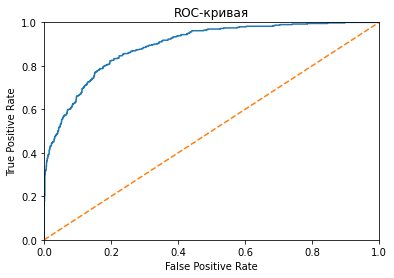

acc: 0.723207948899929


In [83]:
probabilities_test = model_with_early_stop.predict_proba(feature_test)
probabilities_one_test = probabilities_test[:, 1]
print(f'auc_roc: {roc_auc_score(target_test, probabilities_one_test)}')
curve(target_test, probabilities_one_test)
# вычисление accuracy
predictions = model_random.predict(feature_test_full)
acc = accuracy_score(target_test_full, predictions)
print(f'acc: {acc}')

## Борьба с дисбалансом классов

In [84]:
(data[data['EndDate'] == 1].count() / data[data['EndDate'] == 0].count())[0]

0.36122922303826827

In [85]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=80822)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=80822)] + [target_ones])
 # Перемешиваем   
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [86]:
features_downsampled, target_downsampled = downsample(feature_train, target_train, 0.36)

In [87]:
model_with_downsampled=CatBoostClassifier(
    eval_metric='AUC',
    iterations=800,
    random_seed=80822,
    learning_rate=0.04,
    early_stopping_rounds=20,
    depth = 6,
    boosting_type = 'Ordered'
)

model_with_downsampled.fit(
    features_downsampled, target_downsampled,
    cat_features=cat_features,
    eval_set=(feature_test, target_test),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## Вывод

* Значение метрики на тестовой выборки с использованием модели CatBoostClassifier составило 0.893 с использованием параметра  auto_class_weights. 
* Уменьшение выборки для достижения баланса между классами не привело к значительному увеличению метрики. В данном случае метрика составила 0.888 на тестовой выборке.

## XGBClassifier

In [88]:
param_xgb = {
    'max_depth':range(3,10),
    'min_child_weight':range(1,6,2),
    'learning_rate': np.arange(0.01, 0.3, 0.01),
    'n_estimators': range(20, 150, 5)
}

xgb = XGBClassifier(objective= 'binary:logistic', scale_pos_weight=1, seed=27, random_state=80822)
rs_model=RandomizedSearchCV(xgb,
                            param_distributions=param_xgb,
                            n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)
rs_model.fit(feature_train_best, target_train_best)
rs_model.best_params_, rs_model.best_score_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/Users/daivanov/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/daivanov/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/daivanov/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/daivanov/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/xgboost/compat.py:36: F

/Users/daivanov/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/daivanov/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/daivanov/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be remo

/Users/daivanov/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/daivanov/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/daivanov/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be remo

[17:56:17] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'n_estimators': 140,
  'min_child_weight': 5,
  'max_depth': 6,
  'learning_rate': 0.24000000000000002},
 0.8912993923067042)

При обучении на всех данных без выбора наилучших признаков.
Лучшие параметры: learning_rate - 0.25, max_depth - 5, min_child_weight - 5, n_estimators - 85. Значение метрики- 0.883. 

[17:56:39] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
acc: 0.85805535841022
auc_roc: 0.9074482272715835


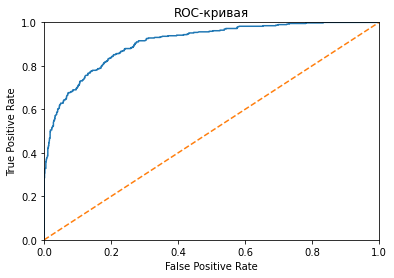

[17:54:38] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5] END learning_rate=0.24000000000000002, max_depth=6, min_child_weight=5, n_estimators=140;, score=0.892 total time=  25.6s
[17:55:04] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END learning_rate=0.28, max_depth=9, min_child_weight=3, n_estimators=55;, score=0.895 total time=  14.8s
[17:55:19] WARNING: /var/folders/s

In [89]:
model = XGBClassifier(
                      random_state=80822,
                      n_estimators= 85,
                      max_depth = 5,
                      learning_rate=0.25
)

model.fit(feature_train_best, target_train_best)
predictions = model.predict(feature_test_best)
acc = accuracy_score(target_test_best, predictions)
print(f'acc: {acc}')

probabilities_test = model.predict_proba(feature_test_best)
probabilities_one_test = probabilities_test[:, 1]
print(f'auc_roc: {roc_auc_score(target_test_best, probabilities_one_test)}')
curve(target_test_full, probabilities_one_test)

# Вывод

Наилучшей моделью оказалась модель GradientBoostingClassifier. Метрика на тестовой выборке составила 0.91, а accuracy - 0.895.

# Отчет

Целью проекта являлось прогнозирование оттока клиентов оператора связи «Ниединогоразрыва.ком». Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах. Данные предоставлены за период с 2013 года по 1 февраля 2020 года. 

**При первичной обработке данных:**
* дубликатов и аномалий выявлено не было. 
* Пропущенные значения в колонке `TotalCharges` были у клиентов, которые заключили контракт на момент выгрузки данных. Такие клиенты заключили долгосрочные контракты и для них в колонке с ежемесячной платой была указана сумма, поэтому пропущенные значения для них заполняли исходя из ежемесячной выплаты и срока заключения договора.
* Тип данных в колонках был изменен в зависимости от хранящихся данных. Например, тип данных в колонке `BeginDate` был изменен на дату.

**В ходе исследовательского анализа данных было обнаружено следующие:**
* Всего 7043 пользователя, из них 1869 отказались от услуг компании. Все 1869 пользователей прекратили использование услуг в конце 2019 года и начале 2020. Больше всего договоров на предоставление услуг было заключено в 2019.
* Только 8.5% пользователей используют максимальный пакет дополнительных услуг при подключении интернета.

**Типичный клиент компании:**
* Предпочитает бумажную версию чека и электронный способ оплаты.
* Предпочитает оплату ежимесячно, а не заключение договора на 1-2 года.
* В среднем пользователь тратит на услуги компании 64.7 рублей в месяц.
* Имеет стабильный источник дохода (количество работающих людей превышает количество пенсионеров).
* Пользователи предпочитают оптоволоконный кабель больше, чем цифровую абонентскую линию.
* Зачастую, пользователи отказываются от использования антивируса, блокировки небезопасных сайтов, а также от облачного хранилища файлов для резервного копирования данных.
* Пользователи поровну разделились на тех кто использует стриминговое телевидение и каталог фильмов и тех кто отказывается от услуги.
* В равной степени может являться и мужчиной и женщиной

**При подготовке данных для обучения модели было выпонено следующее:**
* Преобразовали колонку с информацией о целевом признаке `EndDate`. Где 0 - означает, что пользователь пользуется услугами до сих пор, а 1 - пользователь ушел от компании.
* Из двух столбцов с информацией о дате начала и окончания сотрудничества клиента с компанией сформировали новый признак - время жизни клиента в днях. 
* Удалили клонку с датой начала контракта, так как этот признак не будет использоваться при обучении модели.
* Целевой признак и остальные признаки сохранили в отдельные переменные.
* Построили график важности признаков и узнали что самым важным признаком является - время жизни клиента.
* С помощью SelectKBest были выбраны 10 наилучших признаков для обучения модели.
* Категориальные данные были кодированы техникой OHE. Количественные признаки были масштабированы. 
* Для тестирования модели было выбрано 20 процентов от всех данных.

**При обучении модели выполнили следующие шаги:**
* Построили простейшую модель и посмотрели какое значение метрик она предсказывает, что бы в дальнейшем проверять модели на адекватность.
* Для четырех моделей (RandomForestClassifier, LogisticRegression, DecisionTreeClassifier, GradientBoostingClassifier) подобрали параметры с помощью RandomizedSearchCV и с помощью кросс-валидации рассчитали метрику ROC-AUC. Подбор параметров и рассчет метрики осуществляли на двух наборах данных (с сохранением всех признаков и только с наилучшими признаками). Среди этих моделей наилучшей оказалась модель GradientBoostingClassifier при обучении с использованием всех признаков. Параметры модели: random_state=80822, n_estimators= 74, max_depth = 4, learning_rate=0.16. Mетрика на обучающей выборке 0.893. На тестовой выборке значение метркики ROC-AUC составило 0.905, а accuracy - 0.861.
* Так же обучали и подбирали параметры для моделей CatBoostClassifier и XGBClassifier. Данные модели по значению метрики уступали модели GradientBoostingClassifier.
* На практике было показано, что нет критической разницы в способе борьбы с дисбалансом. Значение метрики для CatBoostClassifier при использовании auto_class_weights и при использовании функции, позволяющей регилировать дисбалан класса, не различается.

**Вывод**
Наилучшей модель для решения поставленной задачи проекта: GradientBoostingClassifier, с гипперпараметрами random_state=80822, n_estimators= 74, max_depth = 4, learning_rate=0.16. Значением ROC-AUC на тестовой выборе 0.905 и accuracy - 0.861.

При выполнении проекта возникли следующие сложности:
* Не до конца понятно в каком случае стоит применять PCA, приимущетсвенно при работе с количетвенными данными? Изначально я попробовала такой способ уменьшения размерности, но в итоге отказалась от дальнейшего его использования.
* При вызове метода feature_importances_ (в конце главы 7.2) для конкретной модели и mutual_info_classif (в начале 6.1.1). Важность признаков немного, но различается. Зависит от того, что происходит внутри этого метода? 